# Project By Datacamp
### Solution Proposal by: André Fernandes
### Found me on:
#### -> https://github.com/vBarFace 
#### -> https://www.linkedin.com/in/andr%C3%A9-fernandes-868006207/

# ------------------------------------

## Exercise introduction by Datacamp: 

###### Fashion Forward is a new AI-based e-commerce clothing retailer. They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

###### As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

# ------------------------------------

## Project Instructions:

###### Automate product tagging for the e-commerce store using CNNs.
###### - Once trained (keeping the epochs to 1 or 2 to keep the run time down), store your predictions on the test set in a list named predictions.
###### - Calculate the accuracy, and per-class precision and recall for your classifier based on the predictions obtained. Store your metrics in variables named accuracy, precision, and recall. Use lists of the appropriate length for the precision and recall.

# ------------------------------------

### Given code by Datacamp:

In [5]:
# Run the cells below first

In [6]:
# If you dont have, install

#!pip install torchmetrics
#!pip install torchvision

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall

In [8]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [9]:
# Start coding here
# Use as many cells as you need

# ------------------------------------

# Lets visualize data first

Size of Training Dataset:  60000
Size of Test Dataset:  10000
All labels:  {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


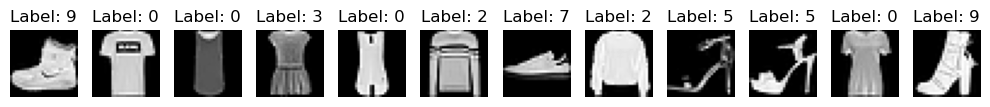

In [12]:
import matplotlib.pyplot as plt

# Lets see the size of the dataset
print("Size of Training Dataset: ", len(train_data))
print("Size of Test Dataset: ", len(test_data))
print("All labels: ", train_data.class_to_idx)

# Define a function to print some images of dataset
def show_images(data, num_images):
    # Inicialize the figure
    plt.figure(figsize=(10, 10))
    # Run through the num_images you want to see
    for i in range(num_images):
        image, label = data[i] # Get the data from each image
        image = image.numpy().squeeze()  # Convert the tensor to a numpy array and remove the channel dimension
        
        # Create a subplot for each image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray') # Use the color map as gray
        plt.title(f'Label: {label}') # Make the label on top of the image
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display the first 5 images from the training dataset
n_images = 12
show_images(train_data, n_images)

In [13]:
# Use Dataloader on the training_data
batch_size = 20
dataloader_train = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

# Lest see our features
features, labels = next(iter(dataloader_train))
print("Shape of Features: ", features.shape)

# Number of unique labels
n_unique_labels = len(train_data.class_to_idx)
print("Unique labels: ", n_unique_labels)

# Lets see what does each index means
batch_size, channels, height, width = features.shape
print(f"There is/are {batch_size} sample(s), {channels} channel(s) per image, and each image is {height}x{width} pixels.")

# Lest see some examples of teh data
print(f"\nFeatures for Training:{features},\nLabels for Training: {labels}")

Shape of Features:  torch.Size([20, 1, 28, 28])
Unique labels:  10
There is/are 20 sample(s), 1 channel(s) per image, and each image is 28x28 pixels.

Features for Training:tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.4235, 0.3294, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 0.6627],
          [0.0000, 0.0000, 0.0000,  ..., 0.8902, 0.9176, 0.3882],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.8941, 0.8431, 0.0706],
          [0.0000, 0.0039, 0.0118,  ..., 0.8745, 0.8824, 0.0941],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],

# Lets define the model

In [15]:
# Lets define the a class for the model
class MulticlassCNN(nn.Module):

    def __init__(self, n_classes, classifier_choosing):
        super().__init__()
        # Define a block that will extract features from images
        self.feature_extractor = nn.Sequential(
            # Convolutional layer: in_channels = 1 because images are gray scale. Most commun kernel is 3x3
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1), # 32 x 28 x 28
            #  Rectilinear Unit
            nn.ReLU(),
            # Pooling layer. Most commun kernel is 2 x 2
            nn.MaxPool2d(kernel_size=2), # 32 x 14 x 14
            # Convolutional layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # 64 x 14 x 14
            #  Rectilinear Unit
            nn.ReLU(),
            # Pooling layer.
            nn.MaxPool2d(kernel_size=2), # 64 x 7 x 7
            # Make input from 2D to 1D
            nn.Flatten(),
        )
        # Define a classifier
        if classifier_choosing == 0:
            self.classifier = nn.Linear(64 * 7 * 7, n_classes)
            self.classifier1 = nn.Softmax(dim=1)
        else:
            self.classifier = nn.Linear(64 * 7 * 7, n_classes)

    def forward(self, x, classifier_choosing):
        x = self.feature_extractor(x) # Pass the data for the feature extracing
        if classifier_choosing == 0:
            x = self.classifier(x) # Finally, classify it
            x = self.classifier1(x) # Finally, classify it
            return x
        else:
            x = self.classifier(x) # Finally, classify it
            return x

# Some parameters before tranning 

In [17]:
# Define the optimizer
learning_rate = 0.001
    
# Define variables to training loop
num_epochs = 35
total_steps = len(dataloader_train)

# Define the loss we will lose
loss_criterion = nn.CrossEntropyLoss()
# -> Used for classification tasks; 
# -> Works with probabilities (usually combined with a softmax layer);
# -> Measures the difference between the predicted probability distribution and the true distribution;
# -> The gradients derived from Cross-Entropy Loss can help with better convergence in classification tasks because 
# they account for the logarithmic nature of probabilities.
# -> Use Cross-Entropy Loss for classification problems where the output is one of several classes and the tasks are binary or multi-class.
# -> MSE Loss is for a regression problems where the output is a continuous value where the goal is to predict a numeric quantity.

import os
# Define paths for saving and loading the CNN model with Softmax
model_softmax_path = 'CNN_model_softmax.pth'
lossEpoch_softmax_path = 'lossEpoch_softmax.png'
# Define paths for saving and loading the CNN model with Linear
model_linear_path = 'CNN_model_linear.pth'
lossEpoch_linear_path = 'lossEpoch_linear.png'

# Lets make the training loop - Using Softmax as activation function

No molde saved found -> Beginning Training...

DONT FORGET:
Training data has 60000 images and the batch size is 20.

Epoch 1 began!
Epoch [1/35], Step [100/3000], Loss: 2.0516
Epoch [1/35], Step [200/3000], Loss: 1.9421
Epoch [1/35], Step [300/3000], Loss: 1.9179
Epoch [1/35], Step [400/3000], Loss: 1.8993
Epoch [1/35], Step [500/3000], Loss: 1.7969
Epoch [1/35], Step [600/3000], Loss: 1.7665
Epoch [1/35], Step [700/3000], Loss: 1.7671
Epoch [1/35], Step [800/3000], Loss: 1.7507
Epoch [1/35], Step [900/3000], Loss: 1.7573
Epoch [1/35], Step [1000/3000], Loss: 1.7576
Epoch [1/35], Step [1100/3000], Loss: 1.7568
Epoch [1/35], Step [1200/3000], Loss: 1.7585
Epoch [1/35], Step [1300/3000], Loss: 1.7597
Epoch [1/35], Step [1400/3000], Loss: 1.7377
Epoch [1/35], Step [1500/3000], Loss: 1.7451
Epoch [1/35], Step [1600/3000], Loss: 1.7512
Epoch [1/35], Step [1700/3000], Loss: 1.7393
Epoch [1/35], Step [1800/3000], Loss: 1.7584
Epoch [1/35], Step [1900/3000], Loss: 1.7160
Epoch [1/35], Step [2

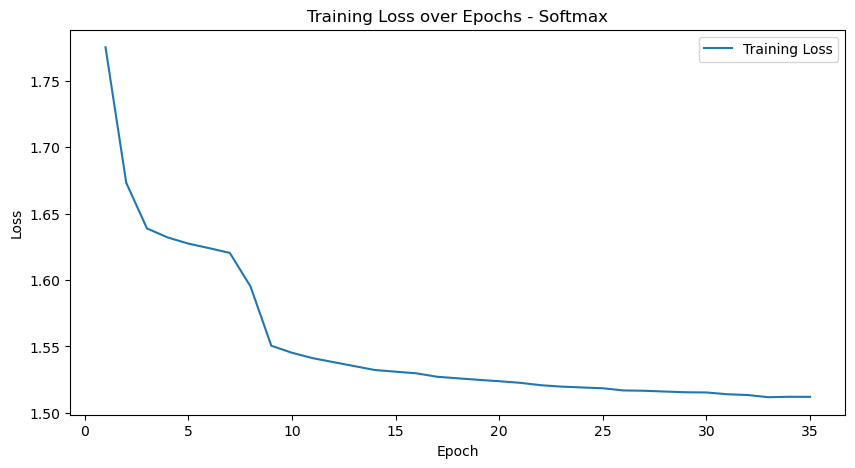

Saved the Softmax Loss plot to lossEpoch_softmax.png


In [19]:
from PIL import Image

# Check if the model file exists
if os.path.exists(model_softmax_path):
    # Load the existing model
    model_softmax = MulticlassCNN(n_unique_labels, 0)
    model_softmax.load_state_dict(torch.load(model_softmax_path))
    print("Loaded existing CNN model with Softmax from", model_softmax_path)
    
    # Lets show the loss graph
    image_Loss_Softmax = Image.open(lossEpoch_softmax_path)
    image_Loss_Softmax.show()

else:

    print("No molde saved found -> Beginning Training...\n")
    
    # Create the model by calling the class
    model_softmax = MulticlassCNN(n_unique_labels, 0) # 0 to use a Softmax classifier
    
    print(f"DONT FORGET:\nTraining data has {len(train_data)} images and the batch size is {batch_size}.\n")

    # Dedine the optimizer
    optimizer_softmax = torch.optim.Adam(model_softmax.parameters(), lr=learning_rate)

    # Define a list to store epoch losses
    epoch_losses_softmax = []
    
    # Training loop - Iterate over each epoch
    for epoch in range(num_epochs):
        # Define the loss of current epoch
        batch_counter = 0
        epoch_loss = 0
        epoch_loss_total = 0
        print(f"Epoch {epoch + 1} began!")
        # Iterate over each batch
        for images, labels in dataloader_train:
            # Lest reset the gradients (derivatives of the loss function) before
            optimizer_softmax.zero_grad()
            # Forward pass: where we calculate the output of the neural network
            prediction = model_softmax(images, 0)
            # Forward pass: where we calculate the loss of the model based on the predictions and the actual targets
            loss = loss_criterion(prediction, labels)
            # Backward Pass: where we compute the gradients of the loss with respect to each parameter
            loss.backward()
            # Finally we update the parameters
            optimizer_softmax.step()
    
            # Sum the loss of each step of the epoch
            epoch_loss += loss.item()
            epoch_loss_total += loss.item()
            if (batch_counter + 1) % 100 == 0: # Print every 100 batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_counter+1}/{total_steps}], Loss: {epoch_loss / 100:.4f}')
                epoch_loss = 0
    
            # Increment batch_counter
            batch_counter += 1

        # Calculate average epoch loss
        avg_epoch_loss = epoch_loss_total / len(dataloader_train)
        print(f"Loss of Epoch {epoch + 1}: {avg_epoch_loss}")
        epoch_losses_softmax.append(avg_epoch_loss)
    
    print("\nTraining Finished :)")

    # Save the trained model
    torch.save(model_softmax.state_dict(), model_softmax_path)
    print("\nTrained and saved the CNN model with Softmax to", model_softmax_path)

    # Plotting the loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), epoch_losses_softmax, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs - Softmax')
    plt.legend()
    # Save the plot as an image
    plt.savefig(lossEpoch_softmax_path)
    plt.show()
    print(f"Saved the Softmax Loss plot to {lossEpoch_softmax_path}")

# Lets make the training loop - Using Linear as activation function

No molde saved found -> Beginning Training...

DONT FORGET:
Training data has 60000 images and the batch size is 20.

Epoch 1 began!
Epoch [1/35], Step [100/3000], Loss: 1.0746
Epoch [1/35], Step [200/3000], Loss: 0.6718
Epoch [1/35], Step [300/3000], Loss: 0.5550
Epoch [1/35], Step [400/3000], Loss: 0.5067
Epoch [1/35], Step [500/3000], Loss: 0.4786
Epoch [1/35], Step [600/3000], Loss: 0.4701
Epoch [1/35], Step [700/3000], Loss: 0.4377
Epoch [1/35], Step [800/3000], Loss: 0.4430
Epoch [1/35], Step [900/3000], Loss: 0.4083
Epoch [1/35], Step [1000/3000], Loss: 0.3906
Epoch [1/35], Step [1100/3000], Loss: 0.3951
Epoch [1/35], Step [1200/3000], Loss: 0.3983
Epoch [1/35], Step [1300/3000], Loss: 0.3671
Epoch [1/35], Step [1400/3000], Loss: 0.3828
Epoch [1/35], Step [1500/3000], Loss: 0.3605
Epoch [1/35], Step [1600/3000], Loss: 0.3453
Epoch [1/35], Step [1700/3000], Loss: 0.3347
Epoch [1/35], Step [1800/3000], Loss: 0.3263
Epoch [1/35], Step [1900/3000], Loss: 0.3636
Epoch [1/35], Step [2

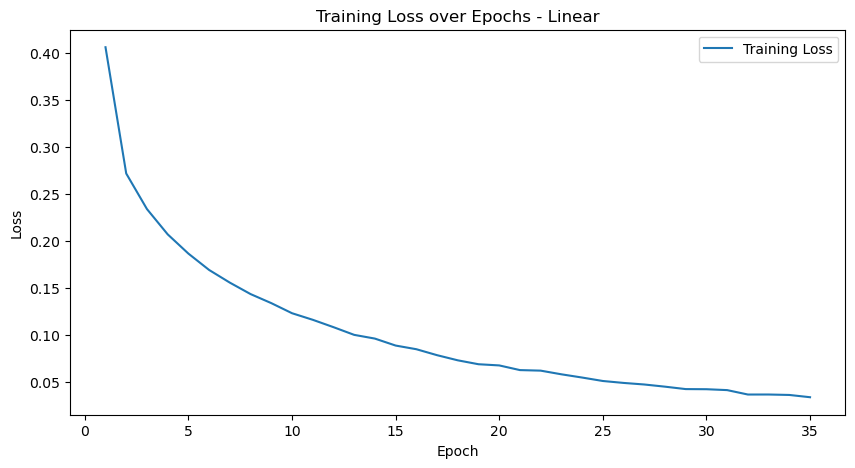

Saved the Softmax Loss plot to lossEpoch_linear.png


In [21]:
# Check if the model file exists
if os.path.exists(model_linear_path):
    # Load the existing model
    model_linear = MulticlassCNN(n_unique_labels, 1)
    model_linear.load_state_dict(torch.load(model_linear_path))
    print("Loaded existing CNN model with Softmax from", model_linear_path)

    # Lets show the loss graph
    image_Loss_linear = Image.open(lossEpoch_linear_path)
    image_Loss_linear.show()

else:

    print("No molde saved found -> Beginning Training...\n")
    
    # Create the model by calling the class
    model_linear = MulticlassCNN(n_unique_labels, 1) # 1 to use a Linear classifier
    
    print(f"DONT FORGET:\nTraining data has {len(train_data)} images and the batch size is {batch_size}.\n")

    # Dedine the optimizer
    optimizer_linear = torch.optim.Adam(model_linear.parameters(), lr=learning_rate)

    # Define a list to store epoch losses
    epoch_losses_linear = []
    
    # Training loop - Iterate over each epoch
    for epoch in range(num_epochs):
        # Define the loss of current epoch
        batch_counter = 0
        epoch_loss = 0
        epoch_loss_total = 0
        print(f"Epoch {epoch + 1} began!")
        # Iterate over each batch
        for images, labels in dataloader_train:
            # Lest reset the gradients (derivatives of the loss function) before
            optimizer_linear.zero_grad()
            # Forward pass: where we calculate the output of the neural network
            prediction = model_linear(images, 1)
            # Forward pass: where we calculate the loss of the model based on the predictions and the actual targets
            loss = loss_criterion(prediction, labels)
            # Backward Pass: where we compute the gradients of the loss with respect to each parameter
            loss.backward()
            # Finally we update the parameters
            optimizer_linear.step()
    
            # Sum the loss of each step of the epoch
            epoch_loss += loss.item()
            epoch_loss_total += loss.item()
            if (batch_counter + 1) % 100 == 0: # Print every 100 batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_counter+1}/{total_steps}], Loss: {epoch_loss / 100:.4f}')
                epoch_loss = 0
    
            # Increment batch_counter
            batch_counter += 1

        # Calculate average epoch loss
        avg_epoch_loss = epoch_loss_total / len(dataloader_train)
        print(f"Loss of Epoch {epoch + 1}: {avg_epoch_loss}")
        epoch_losses_linear.append(avg_epoch_loss)
        
    print("\nTraining Finished :)")

    # Save the trained model
    torch.save(model_linear.state_dict(), model_linear_path)
    print("\nTrained and saved the CNN model with Linear to", model_linear_path)

    # Reshape the losses from (6000,) to (1, 6000)
    #epoch_losses_linear = np.array(epoch_losses_linear).reshape(1, -1)
    
    # Plotting the loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), epoch_losses_linear, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs - Linear')
    plt.legend()
    # Save the plot as an image
    plt.savefig(lossEpoch_linear_path)
    plt.show()
    print(f"Saved the Softmax Loss plot to {lossEpoch_linear_path}")

# Lets test the models we did
###### Calculate accuracy of the model and then precission and recall per-class

In [23]:
# Define both models to evaluation mode
model_softmax.eval()
model_linear.eval()

# Prepare the test dataset
dataloader_teste = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

#### First, lets make prediction with the softmax

In [25]:
# Define the metrcis we will calculate
# -> We will use the averega as "macro" beacuse it computes the metric independently for each class and then takes the average (unweighted mean) 
# of the scores. This treats all classes equally regardless of their imbalance in the data.
metric_accuracy_softmax = Accuracy(task="multiclass", num_classes=n_unique_labels)
metric_precision_softmax = Precision(task="multiclass", num_classes=n_unique_labels, average=None) 
metric_recall_softmax = Recall(task="multiclass", num_classes=n_unique_labels, average=None)

# Lets define the evaluation loop
with torch.no_grad():
    # Run though test images batches
    for images, labels in dataloader_teste:
        # Get output from model
        outputs = model_softmax(images, 0)
        # Predicted class label
        _, predictions = torch.max(outputs, 1)
        # Calculate the metrics
        metric_accuracy_softmax(predictions, labels)
        metric_precision_softmax(predictions, labels)
        metric_recall_softmax(predictions, labels)

# Compute the Metrics
accuracy_softmax = metric_accuracy_softmax.compute()
precision_softmax = metric_precision_softmax.compute()
recall_softmax = metric_recall_softmax.compute()

print("Remeber: ", test_data.class_to_idx)
print("\nAccuracy of model using Softmax: ", accuracy_softmax)
print("Precision using Softmax per-class: ", precision_softmax)
print("Recall using Softmax per-class: ", recall_softmax)

Remeber:  {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}

Accuracy of model using Softmax:  tensor(0.9105)
Precision using Softmax per-class:  tensor([0.8591, 0.9869, 0.8884, 0.9054, 0.7911, 0.9909, 0.7760, 0.9536, 0.9741,
        0.9826])
Recall using Softmax per-class:  tensor([0.8660, 0.9800, 0.8440, 0.9090, 0.9050, 0.9840, 0.6930, 0.9860, 0.9780,
        0.9600])


#### Now, lets make prediction with the Linear

In [27]:
# Define the metrcis we will calculate
# -> We will use the averega as "macro" beacuse it computes the metric independently for each class and then takes the average (unweighted mean) 
# of the scores. This treats all classes equally regardless of their imbalance in the data.
metric_accuracy_linear = Accuracy(task="multiclass", num_classes=n_unique_labels)
metric_precision_linear = Precision(task="multiclass", num_classes=n_unique_labels, average=None) 
metric_recall_linear = Recall(task="multiclass", num_classes=n_unique_labels, average=None)

# Lets define the evaluation loop
with torch.no_grad():
    # Run though test images batches
    for images, labels in dataloader_teste:
        # Get output from model
        outputs = model_linear(images, 1)
        # Predicted class label
        _, predictions = torch.max(outputs, 1)
        # Calculate the metrics
        metric_accuracy_linear(predictions, labels)
        metric_precision_linear(predictions, labels)
        metric_recall_linear(predictions, labels)

# Compute the Metrics
accuracy_linear = metric_accuracy_linear.compute()
precision_linear = metric_precision_linear.compute()
recall_linear = metric_recall_linear.compute()

print("Remeber: ", test_data.class_to_idx)
print("\nAccuracy of model using Softmax: ", accuracy_linear)
print("Precision using Softmax per-class: ", precision_linear)
print("Recall using Softmax per-class: ", recall_linear)

Remeber:  {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}

Accuracy of model using Softmax:  tensor(0.9103)
Precision using Softmax per-class:  tensor([0.8722, 0.9939, 0.8243, 0.8807, 0.8830, 0.9899, 0.7398, 0.9572, 0.9908,
        0.9788])
Recall using Softmax per-class:  tensor([0.8260, 0.9840, 0.8870, 0.9300, 0.8300, 0.9770, 0.7420, 0.9840, 0.9730,
        0.9700])


#### Lets compare the results

In [29]:
# Define a fucntion to plot the metrics
def plot_metrics_bar(title, labels, softmax_metrics, linear_metrics, metric_name):
    
    x = np.arange(len(labels)) # Creates a NumPy array containing integers from 0 to labels
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, softmax_metrics, width, label='Softmax')
    rects2 = ax.bar(x + width/2, linear_metrics, width, label='Linear')

    ax.set_xlabel('Classes')
    ax.set_ylabel(metric_name)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()

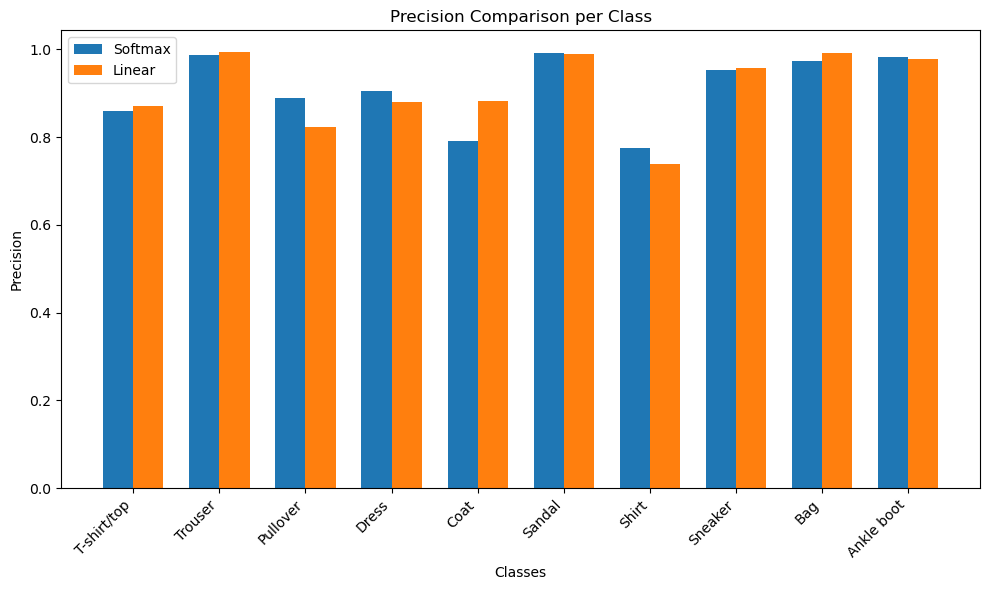

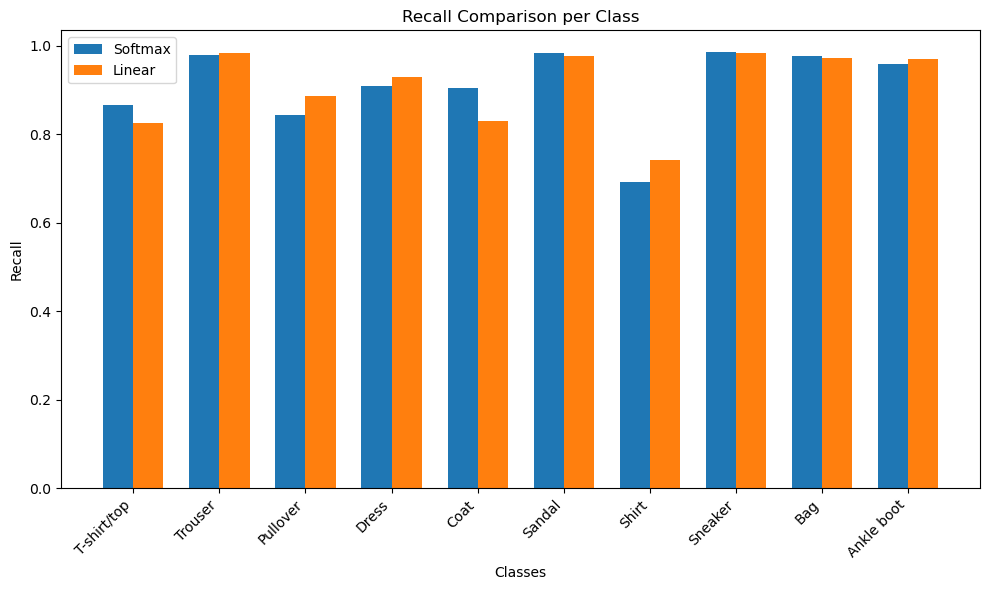


Overall Accuracy Comparison:
Softmax:  tensor(0.9105)
Linear:  tensor(0.9103)


In [30]:
# Define the labels for classes
class_names = sorted(
    test_data.class_to_idx.keys(),
    key = lambda x: test_data.class_to_idx[x] # Lambda sortes based on index and not by name
)

# Prepare data for plotting - convert Tensor to List
precision_softmax_per_class = precision_softmax.tolist()
precision_linear_per_class = precision_linear.tolist()
recall_softmax_per_class = recall_softmax.tolist()
recall_linear_per_class = recall_linear.tolist()

# Plot Precision comparison
plot_metrics_bar('Precision Comparison per Class', class_names, precision_softmax_per_class, precision_linear_per_class, 'Precision')
# Plot Recall comparison
plot_metrics_bar('Recall Comparison per Class', class_names, recall_softmax_per_class, recall_linear_per_class, 'Recall')
# Print overall Accuracy
print("\nOverall Accuracy Comparison:")
print("Softmax: ", accuracy_softmax)
print("Linear: ", accuracy_linear)

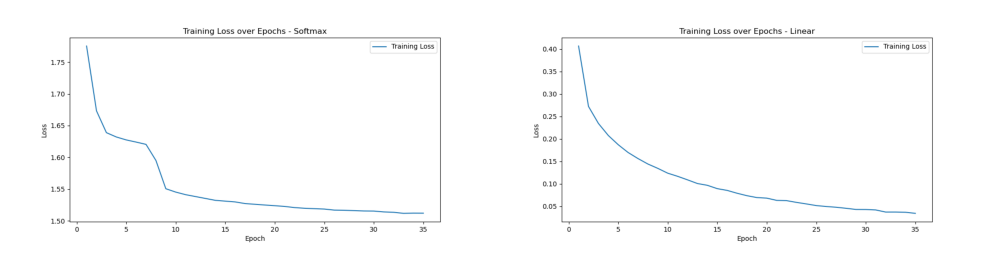

In [31]:
# Lets comapre Losses side by side

loss_softmax = Image.open(lossEpoch_softmax_path)
loss_linear = Image.open(lossEpoch_linear_path)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot image1 in the first subplot
axs[0].imshow(loss_softmax)
axs[0].axis('off')

# Plot image2 in the second subplot
axs[1].imshow(loss_linear)
axs[1].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()